# NavVis HLoc pipeline
This notebook builds a NavVis-style SfM map with HLoc (pycolmap Option B) and localizes RGB-only queries. It mirrors `scripts/demo_hloc.ipynb` with explicit caching under `outputs/hloc/<session>/`.

## Setup

In [1]:
import sys
import csv
import json
import random
from copy import deepcopy
from pathlib import Path

import h5py
import numpy as np
import torch
from tqdm import tqdm

repo_root = Path.cwd().resolve()
if not (repo_root / "data").exists() and (repo_root.parent / "data").exists():
    repo_root = repo_root.parent

sys.path.append(str(repo_root / "third_party" / "Hierarchical-Localization"))
from hloc import extract_features, match_features, pairs_from_retrieval, reconstruction, visualization
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster
from hloc.utils import viz_3d
from hloc.utils.io import get_keypoints, get_matches, write_poses
from hloc.utils.parsers import names_to_pair, parse_retrieval
from hloc.utils.viz import plot_keypoints, plot_matches
from hloc.visualization import plot_images, read_image
import pycolmap

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


Device: cuda


In [2]:
# Dataset + pipeline parameters
session_dir = repo_root / "data/navvis_2022-02-06_12.55.11"
mapping_dir_default = session_dir / "raw_data" / "images_undistr_center"
image_list_path = session_dir / "images.txt"
sensors_path = session_dir / "sensors.txt"
query_dir = repo_root / "data/test_images"
output_root = repo_root / "outputs/hloc" / session_dir.name

# Pairing + localization knobs
top_k_retrieval = 20  # database images per query
top_k_map_retrieval = 16  # optional retrieval neighbors for mapping pairs
seq_overlap = 8  # sequential window for mapping pairs
ransac_max_error = 12.0  # px

# Optional manual intrinsics if EXIF is missing on queries
manual_query_camera = None  # e.g., {"model": "PINHOLE", "width": 1920, "height": 1280, "params": [fx, fy, cx, cy]}

# HLoc configs
feature_conf = deepcopy(extract_features.confs["superpoint_aachen"])
feature_conf["model"]["device"] = device
matcher_conf = deepcopy(match_features.confs["superglue"])
matcher_conf["model"]["device"] = device
global_conf = deepcopy(extract_features.confs["netvlad"])
global_conf["model"]["device"] = device

paths = {
    "features": output_root / "features",
    "global": output_root / "global",
    "pairs": output_root / "pairs",
    "matches": output_root / "matches",
    "sfm": output_root / "sfm",
    "loc": output_root / "localization",
}
for p in paths.values():
    p.mkdir(parents=True, exist_ok=True)

map_features_path = paths["features"] / f"{feature_conf['output']}_mapping.h5"
query_features_path = paths["features"] / f"{feature_conf['output']}_queries.h5"
map_global_path = paths["global"] / f"{global_conf['output']}_mapping.h5"
query_global_path = paths["global"] / f"{global_conf['output']}_queries.h5"
map_pairs_seq_path = paths["pairs"] / f"pairs-map-seq-overlap{seq_overlap}.txt"
map_pairs_retr_path = paths["pairs"] / f"pairs-map-retrieval-top{top_k_map_retrieval}.txt"
map_pairs_path = paths["pairs"] / "pairs-map-combined.txt"
map_matches_path = paths["matches"] / f"{matcher_conf['output']}_map.h5"
loc_pairs_path = paths["pairs"] / f"pairs-query-top{top_k_retrieval}.txt"
loc_matches_path = paths["matches"] / f"{matcher_conf['output']}_loc.h5"
loc_results_path = paths["loc"] / "hloc_navvis_results.txt"


In [3]:
# Helper utilities
def log_skip(path: Path, action: str) -> bool:
    if path.exists():
        print(f"Found existing {path}, skipping {action}.")
        return True
    return False


def load_sensors(path: Path):
    cameras = {}
    if not path.exists():
        return cameras
    with path.open("r", encoding="utf-8") as f:
        for row in csv.reader(f):
            if not row or row[0].startswith("#"):
                continue
            if len(row) < 10 or row[2].strip() != "camera":
                continue
            sensor_id = row[0].strip()
            model = row[3].strip()
            width, height = int(row[4]), int(row[5])
            fx, fy, cx, cy = map(float, row[6:10])
            cameras[sensor_id] = {
                "model": model,
                "width": width,
                "height": height,
                "params": [fx, fy, cx, cy],
            }
    return cameras


def load_image_entries(image_list: Path):
    entries = []
    if not image_list.exists():
        return entries
    with image_list.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = [p.strip() for p in line.split(",")]
            if len(parts) < 3:
                continue
            entries.append((parts[1], parts[2]))  # (sensor_id, rel_path)
    # deduplicate while preserving order
    seen = set()
    unique = []
    for sensor_id, rel in entries:
        if rel in seen:
            continue
        seen.add(rel)
        unique.append((sensor_id, rel))
    return unique


def resolve_image_root(session_dir: Path, entries, default_dir: Path):
    rel_paths = [rel for _, rel in entries]
    candidates = [
        (session_dir, rel_paths),
        (session_dir / "raw_data", rel_paths),
        (session_dir, [f"raw_data/{p}" for p in rel_paths]),
    ]
    if default_dir:
        base = [Path(p).name for p in rel_paths]
        candidates.append((default_dir.parent, [f"{default_dir.name}/{b}" for b in base]))
    for root, names in candidates:
        if names and all((root / n).exists() for n in names):
            resolved = list(zip([e[0] for e in entries], names))
            return root, resolved
    raise FileNotFoundError("Could not resolve mapping image root; first missing: " f"{rel_paths[0] if rel_paths else 'n/a'}")


def list_images(image_root: Path, names=None):
    if names is None:
        files = []
        for ext in ["*.jpg", "*.png", "*.jpeg", "*.JPG", "*.PNG"]:
            files += list(image_root.rglob(ext))
        files = sorted(set(files))
        return [p.relative_to(image_root).as_posix() for p in files]
    return names


def build_sequential_pairs(names, overlap):
    pairs = set()
    for i, name in enumerate(names):
        for j in range(i + 1, min(i + overlap + 1, len(names))):
            pairs.add((name, names[j]))
    return pairs


def save_pairs(pairs, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for a, b in sorted(pairs):
            f.write(f"{a} {b}\n")


def read_pairs(path: Path):
    if not path.exists():
        return set()
    pairs = set()
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.strip().split()
            if len(parts) == 2:
                pairs.add((parts[0], parts[1]))
            elif len(parts) > 2 and len(parts) % 2 == 0:
                for i in range(0, len(parts), 2):
                    pairs.add((parts[i], parts[i + 1]))
            else:
                raise ValueError(f"Malformed pair line ({len(parts)} tokens): {line[:120]}")
    return pairs


def normalize_pairs_file(path: Path):
    if not path.exists():
        return
    pairs = read_pairs(path)
    save_pairs(pairs, path)


def infer_query_camera(qpath: Path, fallback=None):
    try:
        return pycolmap.infer_camera_from_image(qpath)
    except Exception as exc:  # pragma: no cover - debugging helper
        if fallback is None:
            raise
        print(f"EXIF intrinsics missing for {qpath.name}, using fallback: {fallback}")
        return pycolmap.Camera(
            model=fallback["model"],
            width=int(fallback["width"]),
            height=int(fallback["height"]),
            params=fallback["params"],
        )


def preview(name_list, root, title):
    subset = [root / n for n in name_list[:6]]
    if subset:
        plot_images([read_image(p) for p in subset], titles=[p.name for p in subset], dpi=75)
    print(title, "shown for", len(subset), "images")


In [4]:
# Resolve dataset layout and cameras
if not session_dir.exists():
    raise FileNotFoundError(f"Session directory not found: {session_dir}")
if not sensors_path.exists():
    print(f"Warning: sensors file missing: {sensors_path}")

cameras = load_sensors(sensors_path)
image_entries = load_image_entries(image_list_path)

if image_entries:
    image_root, resolved = resolve_image_root(session_dir, image_entries, mapping_dir_default)
    mapping_names = [name for _, name in resolved]
    image_sensors = {name: sensor for sensor, name in resolved}
    print(f"Loaded {len(mapping_names)} mapping images from {image_list_path} (order preserved)")
else:
    image_root = mapping_dir_default if mapping_dir_default.exists() else session_dir / "raw_data"
    mapping_names = list_images(image_root)
    image_sensors = {}
    print(f"No images.txt found, listing {len(mapping_names)} images from {image_root}")

query_root = query_dir.parent if query_dir.parent.exists() else query_dir
query_names = sorted(
    [p.relative_to(query_root).as_posix() for p in query_dir.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}]
)
print(f"Queries: {len(query_names)} from {query_dir}")

shared_camera = None
if cameras:
    uniq = {
        (cam["model"], cam["width"], cam["height"], tuple(cam["params"]))
        for cam in cameras.values()
    }
    if len(uniq) == 1:
        shared_camera = list(cameras.values())[0]
    print("Parsed sensors:")
    for sid, cam in cameras.items():
        print(f"  {sid}: {cam['model']} {cam['width']}x{cam['height']} params={cam['params']}")
else:
    print("No sensors.txt detected; will rely on EXIF or manual intrinsics.")

fallback_query_camera = manual_query_camera or shared_camera



Loaded 2408 mapping images from /home/klrshak/work/CNSG/mesh_pipeline/data/navvis_2022-02-06_12.55.11/images.txt (order preserved)
Queries: 4 from /home/klrshak/work/CNSG/mesh_pipeline/data/test_images
Parsed sensors:
  cam0_center: PINHOLE 1280x1920 params=[960.0, 960.0, 639.8245614035088, 959.8245614035088]
  cam1_center: PINHOLE 1280x1920 params=[960.0, 960.0, 639.8245614035088, 959.8245614035088]
  cam2_center: PINHOLE 1280x1920 params=[960.0, 960.0, 639.8245614035088, 959.8245614035088]
  cam3_center: PINHOLE 1280x1920 params=[960.0, 960.0, 639.8245614035088, 959.8245614035088]


Mapping preview shown for 6 images
Query preview shown for 4 images


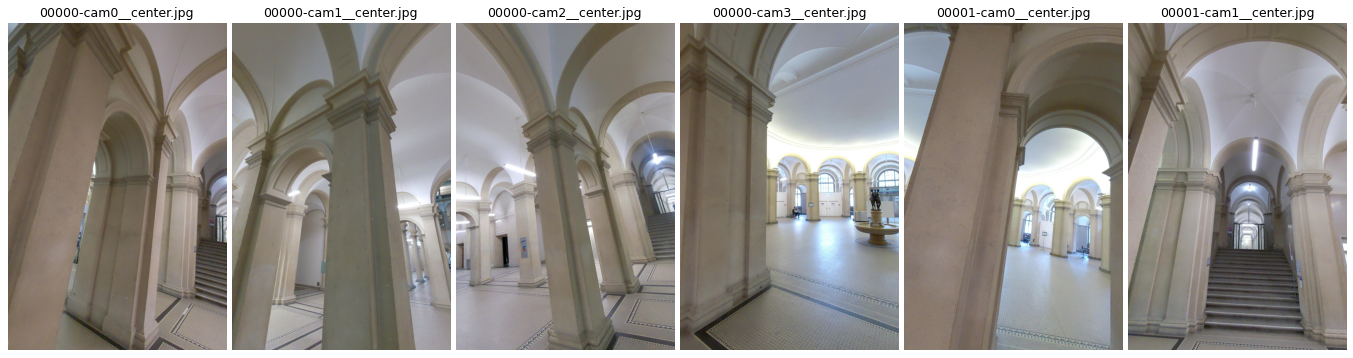

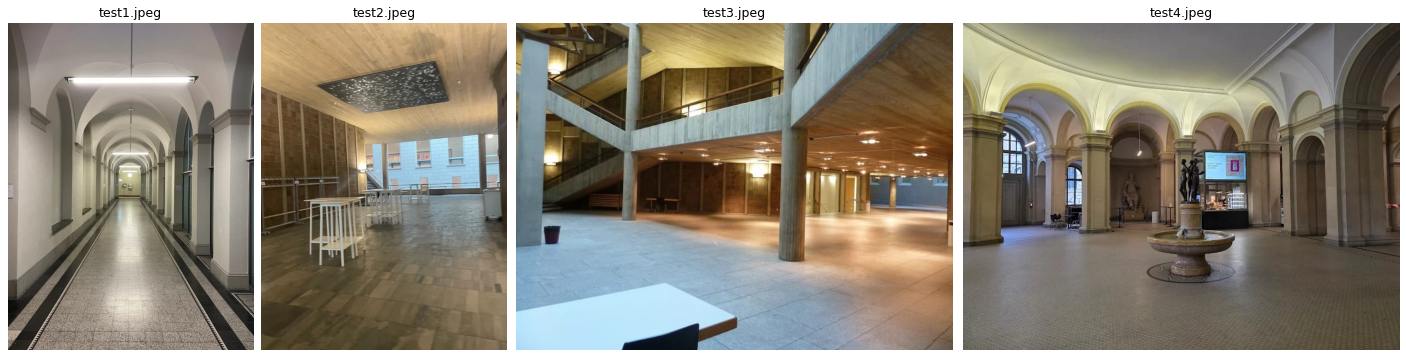

In [5]:
# Dataset preview
preview(mapping_names, image_root, "Mapping preview")
preview(query_names, query_root, "Query preview")

## 3D mapping

In [6]:
# Extract local features for mapping
if not log_skip(map_features_path, "mapping feature extraction"):
    extract_features.main(
        feature_conf,
        image_root,
        image_list=mapping_names,
        feature_path=map_features_path,
    )

Found existing /home/klrshak/work/CNSG/mesh_pipeline/outputs/hloc/navvis_2022-02-06_12.55.11/features/feats-superpoint-n4096-r1024_mapping.h5, skipping mapping feature extraction.


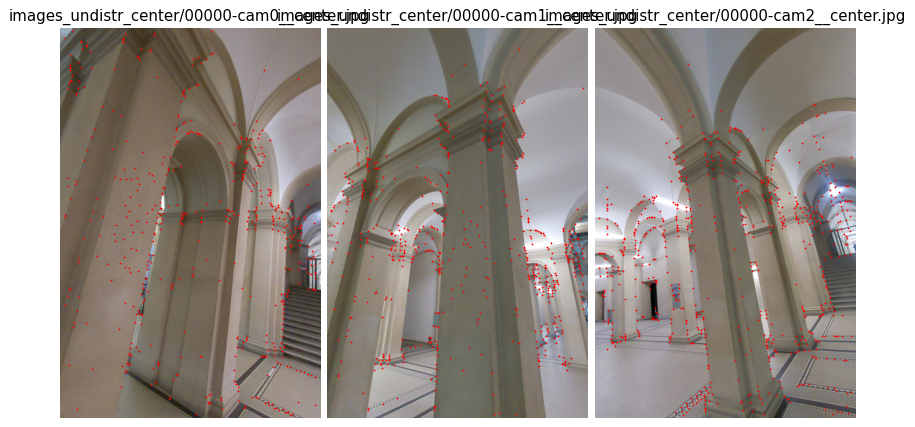

In [7]:
# Visualize keypoints on a few mapping images
with h5py.File(map_features_path, "r") as f:
    vis_names = mapping_names[:3]
    imgs = [read_image(image_root / n) for n in vis_names]
    kps = [np.array(f[n]["keypoints"]) for n in vis_names]
plot_images(imgs, titles=vis_names, dpi=90)
plot_keypoints(kps, colors=["r"] * len(kps), ps=2)

In [8]:
# Match mapping pairs
if not log_skip(map_matches_path, "mapping feature matching"):
    match_features.main(
        matcher_conf,
        pairs=map_pairs_path,
        features=map_features_path,
        matches=map_matches_path,
    )

Found existing /home/klrshak/work/CNSG/mesh_pipeline/outputs/hloc/navvis_2022-02-06_12.55.11/matches/matches-superglue_map.h5, skipping mapping feature matching.


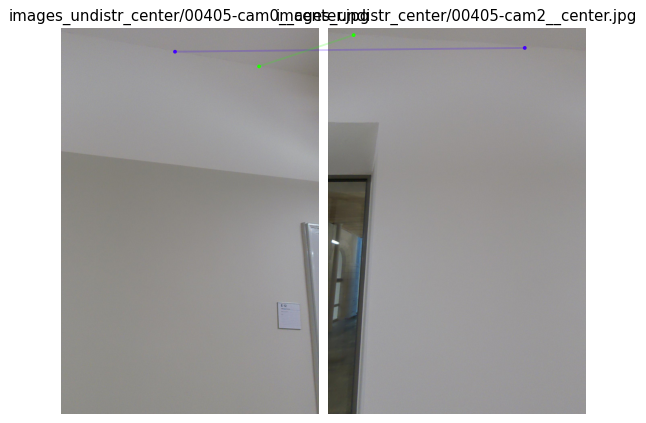

In [9]:
# Visualize matches for one mapping pair
pair_samples = read_pairs(map_pairs_path)
if pair_samples:
    name0, name1 = next(iter(pair_samples))
    matches, _ = get_matches(map_matches_path, name0, name1)
    kpts0 = get_keypoints(map_features_path, name0)
    kpts1 = get_keypoints(map_features_path, name1)
    keep = min(len(matches), 200)
    if keep:
        matches = matches[:keep]
    plot_images(
        [read_image(image_root / name0), read_image(image_root / name1)],
        titles=[name0, name1],
        dpi=90,
    )
    plot_matches(kpts0[matches[:, 0]], kpts1[matches[:, 1]], a=0.2)
else:
    print("No mapping pairs to visualize")

In [ ]:
# Run pycolmap reconstruction (HLoc Option B)
sfm_dir = paths["sfm"]
camera_mode = pycolmap.CameraMode.AUTO
image_options = {}
if shared_camera:
    camera_mode = pycolmap.CameraMode.SINGLE
    image_options = {"camera_model": shared_camera["model"], "camera_params": ",".join(str(p) for p in shared_camera["params"])}
    print("Using shared intrinsics from sensors.txt:", shared_camera)
elif cameras:
    camera_mode = pycolmap.CameraMode.PER_IMAGE
    print("Multiple sensors detected; pycolmap will keep per-image intrinsics.")

if (sfm_dir / "images.bin").exists():
    print(f"Found existing SfM model in {sfm_dir}, loading without recomputing.")
    model = pycolmap.Reconstruction(sfm_dir)
else:
    model = reconstruction.main(
        sfm_dir=sfm_dir,
        image_dir=image_root,
        pairs=map_pairs_path,
        features=map_features_path,
        matches=map_matches_path,
        camera_mode=camera_mode,
        image_list=mapping_names,
        image_options=image_options,
        mapper_options={"ba_refine_principal_point": False},
    )
    if model is None:
        raise RuntimeError("Reconstruction failed; check inputs and pairs.")

print(model.summary())

[2025/12/12 15:38:25 hloc INFO] Writing COLMAP logs to /home/klrshak/work/CNSG/mesh_pipeline/outputs/hloc/navvis_2022-02-06_12.55.11/sfm/colmap.LOG.*
[2025/12/12 15:38:25 hloc WARNING] The database already exists, deleting it.
[2025/12/12 15:38:25 hloc INFO] Creating an empty database...
[2025/12/12 15:38:25 hloc INFO] Importing images into the database...


Using shared intrinsics from sensors.txt: {'model': 'PINHOLE', 'width': 1280, 'height': 1920, 'params': [960.0, 960.0, 639.8245614035088, 959.8245614035088]}


[2025/12/12 15:39:21 hloc INFO] Importing features into the database...
100%|██████████| 2408/2408 [00:02<00:00, 887.98it/s]
[2025/12/12 15:39:23 hloc INFO] Importing matches into the database...
100%|██████████| 53954/53954 [00:56<00:00, 950.09it/s] 
[2025/12/12 15:40:20 hloc INFO] Performing geometric verification of the matches...
[2025/12/12 15:43:17 hloc INFO] Running 3D reconstruction...
Reconstruction 1:  59%|█████▉    | 1426/2408 [1:27:50<04:25,  3.70images/s, registered]     

In [ ]:
# 3D visualization
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, max_reproj_error=8.0, cs=1.5)
fig

visualization.visualize_sfm_2d(model, image_root, color_by="visibility", n=2)


## Localization

In [ ]:
# Global descriptors for queries + retrieval against the map
if not log_skip(query_global_path, "query global descriptor extraction"):
    extract_features.main(
        global_conf,
        query_root,
        image_list=query_names,
        feature_path=query_global_path,
    )

if not log_skip(loc_pairs_path, "query-to-map retrieval"):
    pairs_from_retrieval.main(
        descriptors=query_global_path,
        db_descriptors=map_global_path,
        output=loc_pairs_path,
        num_matched=top_k_retrieval,
        db_list=mapping_names,
    )

retrieval = parse_retrieval(loc_pairs_path)
example_q = next(iter(retrieval.keys())) if retrieval else None
if example_q:
    refs = retrieval[example_q][:min(len(retrieval[example_q]), 6)]
    plot_images(
        [read_image(query_root / example_q)] + [read_image(image_root / r) for r in refs],
        titles=["query"] + refs,
        dpi=90,
    )

In [ ]:
# Extract local features for queries
if not log_skip(query_features_path, "query feature extraction"):
    extract_features.main(
        feature_conf,
        query_root,
        image_list=query_names,
        feature_path=query_features_path,
    )

In [ ]:
# Match queries to their top-K retrieved references
if not log_skip(loc_matches_path, "query-map matching"):
    match_features.main(
        matcher_conf,
        pairs=loc_pairs_path,
        features=query_features_path,
        features_ref=map_features_path,
        matches=loc_matches_path,
    )

In [ ]:
# Localize queries with PnP + RANSAC
loc_logs = {}
retrieval = parse_retrieval(loc_pairs_path)
db_name_to_id = {img.name: i for i, img in model.images.items()}
localizer = QueryLocalizer(
    model,
    {
        "estimation": {"ransac": {"max_error": ransac_max_error}},
        "refinement": {"refine_focal_length": True, "refine_extra_params": True},
    },
)
results = {}
summary_rows = []

for qname in tqdm(query_names, desc="Localizing queries"):
    if qname not in retrieval:
        continue
    db_ids = [db_name_to_id[n] for n in retrieval[qname] if n in db_name_to_id]
    if not db_ids:
        continue
    qpath = query_root / qname
    camera = infer_query_camera(qpath, fallback_query_camera)
    ret, log = pose_from_cluster(
        localizer,
        qname,
        camera,
        db_ids,
        query_features_path,
        loc_matches_path,
    )
    log["covisibility_clustering"] = False
    loc_logs[qname] = log
    num_inliers = ret["num_inliers"] if ret is not None else 0
    summary_rows.append((qname, num_inliers, len(log["keypoint_index_to_db"][0])))
    if ret is not None:
        results[qname] = ret["cam_from_world"]

print(f"Localized {len(results)}/{len(query_names)} queries")
write_poses(results, loc_results_path, prepend_camera_name=False)
with open(f"{loc_results_path}_logs.pkl", "wb") as f:
    import pickle

    pickle.dump(
        {
            "loc": loc_logs,
            "retrieval": retrieval,
            "features": query_features_path,
            "matches": loc_matches_path,
        },
        f,
    )

summary_rows = sorted(summary_rows, key=lambda r: -r[1])
print("Top-5 queries by inliers:")
for row in summary_rows[:5]:
    print(f"  {row[0]}: {row[1]} inliers from {row[2]} correspondences")

In [ ]:
# Localization visualizations
if results:
    sample_q = summary_rows[0][0]
    log = loc_logs[sample_q]
    visualization.visualize_loc_from_log(
        query_root,
        sample_q,
        log,
        reconstruction=model,
        db_image_dir=image_root,
        top_k_db=2,
    )

    fig = viz_3d.init_figure(height=600)
    viz_3d.plot_reconstruction(fig, model, max_reproj_error=10.0, cs=1.2)
    viz_3d.plot_camera_colmap(fig, results[sample_q], scale=2.0, name=f"query: {sample_q}")
    fig
else:
    print("No successful localizations to visualize")

In [ ]:
# Success rate summary
success_rate = len(results) / max(1, len(query_names))
print(f"Success rate: {success_rate*100:.2f}% ({len(results)} / {len(query_names)})")
failed = [q for q in query_names if q not in results]
if failed:
    print("Failed queries (showing up to 5):", failed[:5])
